In [17]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [76]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [77]:
model = Classifier()

images, labels = next(iter(testloader))
ps = torch.exp(model(images))

print(ps.shape)

torch.Size([64, 10])


In [78]:
top_p, top_class = ps.topk(1, dim=1)
print(top_class[:10, : ])

tensor([[7],
        [7],
        [5],
        [5],
        [7],
        [5],
        [7],
        [7],
        [7],
        [7]])


In [79]:
print(top_class.shape)
print(labels.shape)

torch.Size([64, 1])
torch.Size([64])


In [80]:
equal = top_class == labels

In [81]:
equal = top_class == labels.view(*top_class.shape)

In [82]:
accuracy = torch.mean(equal.type(torch.FloatTensor))
print(f'Accuracy:{accuracy.item()*100}%')

Accuracy:7.8125%


In [95]:
print(accuracy)

tensor(0.0781)


In [100]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss= 0
        accuracy=0
        
        with torch.no_grad():
            for images, labels in testloader:
                log_ps= model(images)
                test_loss+= criterion(log_ps, labels) 
                
                ps= torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy+= torch.mean(equals.type(torch.FloatTensor))
                
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                
                
                
        ## TODO: Implement the validation pass and print out the validation accuracy
        print(f'Accuracy: {accuracy.item()*100}%')

Epoch: 1/30..  Training Loss: 0.509..  Test Loss: 0.462..  Test Accuracy: 0.827
Accuracy: 12989.0625%
Epoch: 2/30..  Training Loss: 0.389..  Test Loss: 0.411..  Test Accuracy: 0.854
Accuracy: 13410.9375%
Epoch: 3/30..  Training Loss: 0.357..  Test Loss: 0.396..  Test Accuracy: 0.852
Accuracy: 13379.6875%
Epoch: 4/30..  Training Loss: 0.333..  Test Loss: 0.373..  Test Accuracy: 0.862
Accuracy: 13531.25%
Epoch: 5/30..  Training Loss: 0.318..  Test Loss: 0.397..  Test Accuracy: 0.865
Accuracy: 13584.375%
Epoch: 6/30..  Training Loss: 0.301..  Test Loss: 0.370..  Test Accuracy: 0.871
Accuracy: 13676.5625%
Epoch: 7/30..  Training Loss: 0.291..  Test Loss: 0.380..  Test Accuracy: 0.868
Accuracy: 13625.0%
Epoch: 8/30..  Training Loss: 0.280..  Test Loss: 0.355..  Test Accuracy: 0.875
Accuracy: 13740.625%
Epoch: 9/30..  Training Loss: 0.273..  Test Loss: 0.400..  Test Accuracy: 0.866
Accuracy: 13593.75%
Epoch: 10/30..  Training Loss: 0.267..  Test Loss: 0.363..  Test Accuracy: 0.878
Accuracy: 

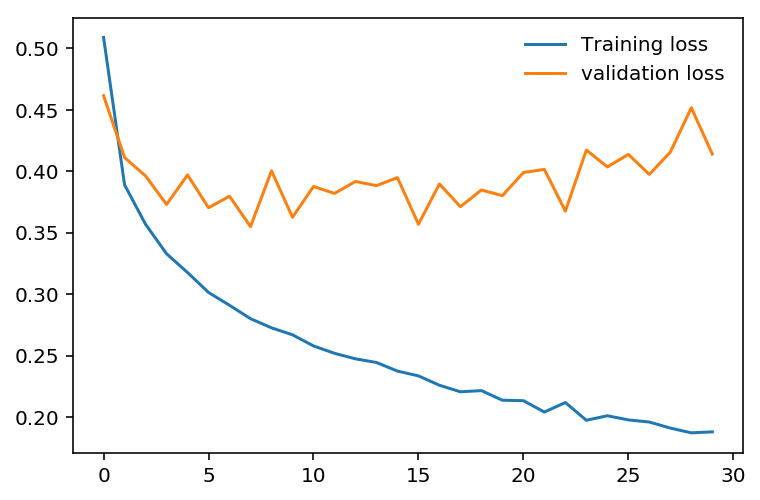

In [107]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label = 'Training loss')
plt.plot(test_losses, label = 'validation loss')
plt.legend(frameon= False)

## With dropout

In [114]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [115]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss= 0
        accuracy=0
        
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps= model(images)
                test_loss+= criterion(log_ps, labels) 
                
                ps= torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy+= torch.mean(equals.type(torch.FloatTensor))
                
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                
                
                
        ## TODO: Implement the validation pass and print out the validation accuracy
        print(f'Accuracy: {accuracy.item()*100}%')

Epoch: 1/30..  Training Loss: 0.615..  Test Loss: 0.470..  Test Accuracy: 0.833
Accuracy: 13079.6875%
Epoch: 2/30..  Training Loss: 0.481..  Test Loss: 0.451..  Test Accuracy: 0.836
Accuracy: 13121.875%
Epoch: 3/30..  Training Loss: 0.451..  Test Loss: 0.422..  Test Accuracy: 0.847
Accuracy: 13295.3125%
Epoch: 4/30..  Training Loss: 0.432..  Test Loss: 0.423..  Test Accuracy: 0.852
Accuracy: 13382.8125%
Epoch: 5/30..  Training Loss: 0.417..  Test Loss: 0.402..  Test Accuracy: 0.857
Accuracy: 13459.375%
Epoch: 6/30..  Training Loss: 0.405..  Test Loss: 0.406..  Test Accuracy: 0.857
Accuracy: 13454.6875%
Epoch: 7/30..  Training Loss: 0.400..  Test Loss: 0.401..  Test Accuracy: 0.859
Accuracy: 13479.6875%
Epoch: 8/30..  Training Loss: 0.396..  Test Loss: 0.376..  Test Accuracy: 0.868
Accuracy: 13634.375%
Epoch: 9/30..  Training Loss: 0.391..  Test Loss: 0.395..  Test Accuracy: 0.862
Accuracy: 13535.9375%
Epoch: 10/30..  Training Loss: 0.387..  Test Loss: 0.416..  Test Accuracy: 0.865
Accu

In [116]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

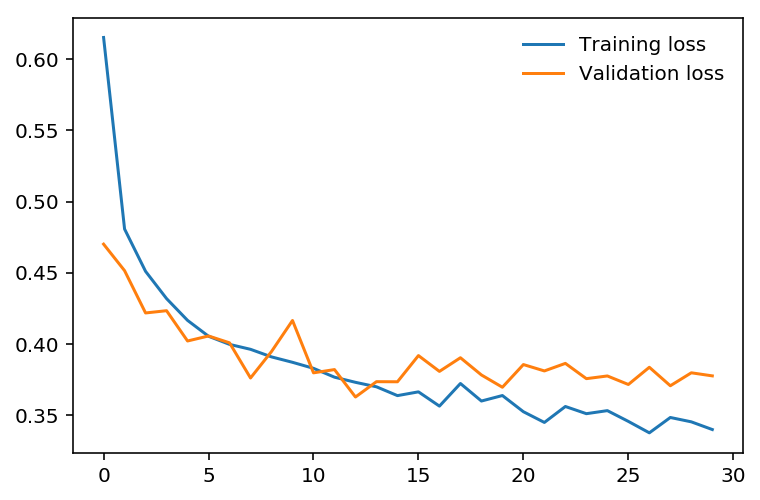

In [117]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing

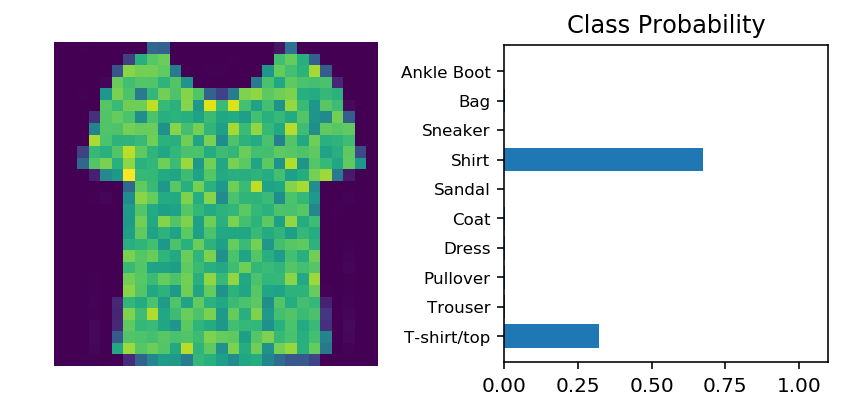

In [153]:
import helper

model.eval()

dataiter= iter(testloader)
images, labels = dataiter.next()
img= images[1]
img = img.view(1,784)

with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

helper.view_classify(img, ps, version='Fashion')